In [1]:
import os
import sys
import time
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from model_settings import ms
jupyter_dir = os.path.abspath(str(Path()))
os.chdir(jupyter_dir)
from mlop import mlop
sys.path.append(os.path.join(jupyter_dir,'train_data'))
sys.path.append(os.path.join(
    jupyter_dir,
    'historical_data',
    'historical_generation'))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format

train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')

print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual


##################
# training start #
##################

Wed Oct  9 23:07:12 2024



# Loading data


importing dataset(s)...



loading: 100%|███████████████████████████████████████████████████████████████████████| 908/908 [00:17<00:00, 50.53it/s]



preparing data...


         spot_price  strike_price       barrier  days_to_maturity  \
count 4796533.00000 4796533.00000 4796533.00000     4796533.00000   
mean     1384.13050    1383.14083    1384.03761         330.26960   
min       849.89000     764.90100     424.94500          60.00000   
25%      1304.46000    1292.06292    1008.52885          90.00000   
50%      1403.52000    1393.71100    1374.41700         360.00000   
75%      1489.28000    1492.56633    1732.03805         540.00000   
max      1565.18000    1721.69800    2347.77000         720.00000   
std       135.54958     157.82669     450.59561         241.58125   

       barrier_price        rebate  dividend_rate  risk_free_rate  \
count  4796533.00000 4796533.00000  4796533.00000   4796533.00000   
mean        54.19922       0.00000        0.02093         0.04000   
min          0.00000       0.00000        0.01780         0.04000   
25%          2.65256       0.00000        0.01882         0.04000   
50%         

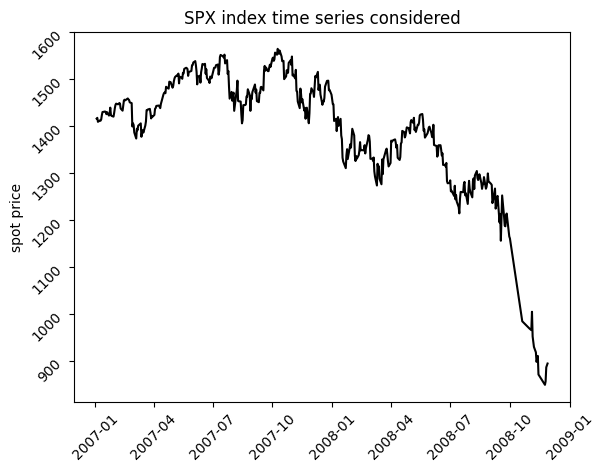

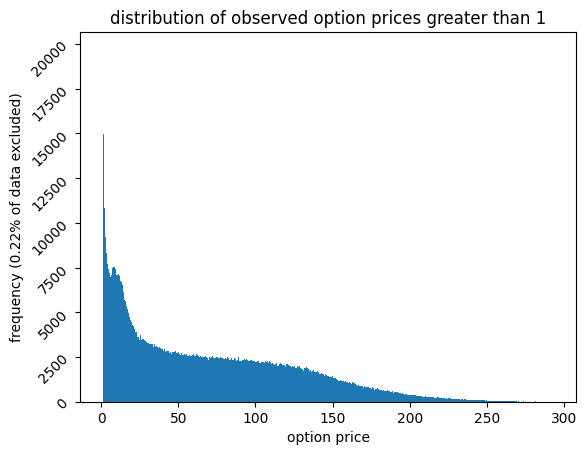

test size: 1.0%
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()



<Figure size 640x480 with 0 Axes>

In [2]:
from HDF_collection import contracts

dataset = contracts.copy()
mlop = mlop(user_dataset = dataset)

# Preprocessing

In [3]:
"""
random train/test split
"""
train_data, train_X, train_y, \
    test_data, test_X, test_y = mlop.split_user_data()

In [4]:
"""
manual train/test split
"""
unique_dates = dataset['calculation_date'].sort_values(
    ascending=True).unique().tolist()
filter_date = unique_dates[int(0.85*len(unique_dates))]

train_data = dataset[
    (
      # (dataset['calculation_date']>=datetime(2007,1,1))
      #  &
        (dataset['calculation_date']<=filter_date)
      )].copy()

test_data = dataset[
    (
      (dataset['calculation_date']>filter_date)
      # &
      # (dataset['calculation_date']<=datetime(2012,12,31))
      )].copy()



In [5]:
"""
preprocessing
"""
train_X, train_y, test_X, test_y = mlop.split_data_manually(
    train_data, test_data)
preprocessor = mlop.preprocess()
train_startdate = train_data.describe()['calculation_date']['min'].strftime('%A, %Y-%m-%d')
train_enddate = train_data.describe()['calculation_date']['max'].strftime('%A, %Y-%m-%d')
print(f"\ntraining from\n{train_startdate}\nto\n{train_enddate}\n")


training from
Wednesday, 2007-01-03
to
Tuesday, 2008-07-15



In [6]:
print(f"\n{train_data.dtypes}")
test_train_ratio = test_data.describe(
    ).iloc[0,0]/train_data.describe().iloc[0,0]

print(f"\ntrain/test: {int(round((1-test_train_ratio)*100,0))}/"
      +str(int(round(test_train_ratio*100,0))))


spot_price                  float64
strike_price                float64
barrier                     float64
days_to_maturity              int64
barrier_price               float64
updown                       object
outin                        object
w                            object
barrier_type_name            object
rebate                      float64
dividend_rate               float64
risk_free_rate              float64
theta                       float64
kappa                       float64
rho                         float64
eta                         float64
v0                          float64
calculation_date     datetime64[ns]
expiration_date      datetime64[ns]
moneyness                   float64
observed_price              float64
dtype: object

train/test: 74/26


# Training

In [7]:
model_fit, runtime, specs = mlop.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: constant
activation: relu
solver: sgd
alpha: 0.0001


# Testing

In [8]:
test_data.describe()

,spot_price,strike_price,barrier,days_to_maturity,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,expiration_date,moneyness,observed_price
count,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257.00000,985257,985257,985257.00000,985257.00000
mean,1189.34484,1188.82047,1190.32292,327.82854,55.55183,0.00000,0.02462,0.04000,0.07068,4.02022,-0.86333,0.33630,0.10608,2008-09-09 22:19:01.826751232,2009-08-03 18:12:07.346469120,2.92228,55.55740
min,849.89000,764.90100,424.94500,60.00000,0.00000,0.00000,0.02227,0.04000,0.05139,0.67288,-1.00000,0.15083,0.02683,2008-07-16 00:00:00,2008-09-14 00:00:00,-0.95821,0.00000
25%,1187.40000,1133.68514,872.20185,90.00000,4.84779,0.00000,0.02275,0.04000,0.05631,1.96304,-1.00000,0.16720,0.03950,2008-08-14 00:00:00,2008-12-19 00:00:00,-0.76777,4.85153
50%,1248.97000,1217.56957,1202.44410,360.00000,37.48954,0.00000,0.02329,0.04000,0.05984,2.76426,-1.00000,0.23100,0.05257,2008-09-08 00:00:00,2009-07-13 00:00:00,-0.16330,37.48424
75%,1274.77000,1295.50302,1472.21603,540.00000,96.48149,0.00000,0.02411,0.04000,0.06438,4.16711,-0.73762,0.32899,0.14256,2008-09-24 00:00:00,2010-03-03 00:00:00,2.79539,96.47768
max,1305.09000,1435.59900,1957.63500,720.00000,248.35434,0.00000,0.03355,0.04000,0.14394,11.87783,-0.24433,1.52388,0.37980,2008-11-28 00:00:00,2010-11-18 00:00:00,22.92665,248.52335
std,129.47383,146.94312,393.30810,241.40341,55.99921,0.00000,0.00304,0.00000,0.02627,2.98735,0.23359,0.29492,0.09413,NaN,NaN,5.94327,55.99406


In [9]:
insample, outsample, errors = mlop.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )


in sample:
     RSME: 4.606804770158888
     MAE: 3.199946642395187

out of sample:
     RSME: 21.051425683501936
     MAE: 10.61625113783416


# Saving

In [10]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] )
os.chdir(os.path.join(jupyter_dir,'trained_models'))
files_dir = os.path.join(
    jupyter_dir,'trained_models','trained_models',
    file_tag)

if Path(files_dir).exists():
    pass
else:
    os.mkdir(files_dir)

file_dir = os.path.join(files_dir,file_tag)

S = np.sort(train_data['spot_price'].unique())
K = np.sort(train_data['strike_price'].unique())
T = np.sort(train_data['days_to_maturity'].unique())
W = np.sort(train_data['w'].unique())
n_calls = train_data[train_data['w']=='call'].shape[0]
n_puts = train_data[train_data['w']=='put'].shape[0]
insample.to_csv(f"{file_dir} insample.csv")
outsample.to_csv(f"{file_dir} outsample.csv")
joblib.dump(model_fit,str(f"{file_dir}.pkl"))
pd.set_option("display.max_columns",None)
with open(f'{file_dir}.txt', 'w') as file:
    file.write(train_start_tag)
    file.write(f"\nspot(s):\n{S}")
    file.write(f"\n\nstrikes:\n{K}\n")
    file.write(f"\nmaturities:\n{T}\n")
    file.write(f"\ntypes:\n{W}\n")
    try:
        file.write(f"\n{train_data['barrier_type_name'].unique()}")
    except Exception:
        pass
    file.write("")
    file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
    file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
    for spec in specs:
        file.write(f"{spec}\n")
    file.write("#"*17+"\n# training data #\n"+"#"*17+
          f"\n{train_data.describe()}\n")
    file.write("#"*13+"\n# test data #\n"+"#"*13+
          f"\n{test_data.describe()}\n")
    file.write(f"\n{dataset.dtypes}")
    file.write(
        f"\nin sample results:"
        f"\n     RMSE: {errors['insample_RMSE']}"
        f"\n     MAE: {errors['insample_MAE']}\n"
        f"\nout of sample results:"
        f"\n     RMSE: {errors['outofsample_RMSE']}"
        f"\n     MAE: {errors['outofsample_MAE']}\n"
        )
    file.write("\nfeatures:\n")
    for feature in mlop.feature_set:
        file.write(f"     {feature}\n")
    file.write(f"\ntarget: {mlop.target_name}\n")
    file.write(f"\ncpu: {train_runtime}\n")
    file.write(datetime.fromtimestamp(train_end).strftime('%c'))

NameError: name 'file_tag_addon' is not defined